<a href="https://colab.research.google.com/github/agungtriu/Belajar-Pengembangan-Machine-Learning/blob/master/Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [136]:
import zipfile,os
#local_zip = '/tmp/FaceMask.zip'
local_zip = '/content/drive/My Drive/Datasets/FaceMask.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [137]:
base_dir = '/tmp/FaceMask'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [138]:
import pandas as pd
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
with_mask       10000
without_mask    10000
dtype: int64

In [139]:
from sklearn.model_selection import train_test_split

X = df['path']
y = df['tag']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=300)

df_tr = pd.DataFrame({'path':X_train, 'tag':y_train, 'set':'train'})
df_val = pd.DataFrame({'path':X_val, 'tag':y_val, 'set':'validation'})

print('train size', len(df_tr))
print('val size', len(df_val))

df_all = df_tr.append([df_val]).reset_index(drop=1)
print(df_all.groupby(['set','tag']).size(),'\n')

df_all.sample(3)

train size 16000
val size 4000
set         tag         
train       with_mask       7992
            without_mask    8008
validation  with_mask       2008
            without_mask    1992
dtype: int64 



,path,tag,set
12429,/tmp/FaceMask/with_mask/with-mask-default-mask...,with_mask,train
3551,/tmp/FaceMask/without_mask/seed4569.png,without_mask,train
8376,/tmp/FaceMask/without_mask/seed7018.png,without_mask,train


In [140]:
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = "/tmp/FaceMask/"
dataset_path = "/tmp/dataset_FaceMask/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [141]:
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')

In [142]:
os.listdir(train_dir)

['with_mask', 'without_mask']

In [143]:
os.listdir(validation_dir)

['with_mask', 'without_mask']

In [144]:
train_withMask_dir = os.path.join(train_dir, 'with_mask')
train_withoutMask_dir = os.path.join(train_dir, 'without_mask')

validation_withMask_dir = os.path.join(validation_dir, 'with_mask')
validation_withoutMask_dir = os.path.join(validation_dir, 'without_mask')

In [145]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [146]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [151]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 75, 75, 16)        448       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 19, 19, 32)        4640      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 2592)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               1327616   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)             

In [152]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95 and logs.get('val_acc')>0.95):
      print("\nAccuracy dan Validation Accuracy dari model > 95%")
      self.model.stop_training = True
callbacks = myCallback()

In [153]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2,
      callbacks=[callbacks])

Epoch 1/10
25/25 - 1s - loss: 0.6691 - acc: 0.5600 - val_loss: 0.7003 - val_acc: 0.3333
Epoch 2/10
25/25 - 1s - loss: 0.4601 - acc: 0.7500 - val_loss: 0.4614 - val_acc: 0.5833
Epoch 3/10
25/25 - 1s - loss: 0.3589 - acc: 0.8500 - val_loss: 0.2255 - val_acc: 0.9167
Epoch 4/10
25/25 - 1s - loss: 0.1809 - acc: 0.9400 - val_loss: 0.2962 - val_acc: 0.9167
Epoch 5/10
25/25 - 1s - loss: 0.1964 - acc: 0.9500 - val_loss: 0.0476 - val_acc: 1.0000
Epoch 6/10
25/25 - 1s - loss: 0.0768 - acc: 0.9800 - val_loss: 0.1431 - val_acc: 0.9167
Epoch 7/10

Accuracy dan Validation Accuracy dari model > 95%
25/25 - 1s - loss: 0.0390 - acc: 0.9900 - val_loss: 0.0245 - val_acc: 1.0000


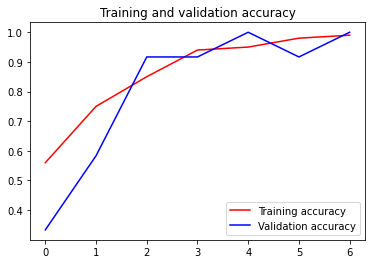

<Figure size 432x288 with 0 Axes>

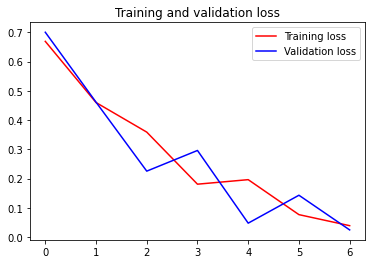

<Figure size 432x288 with 0 Axes>

In [154]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()